In [2]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)


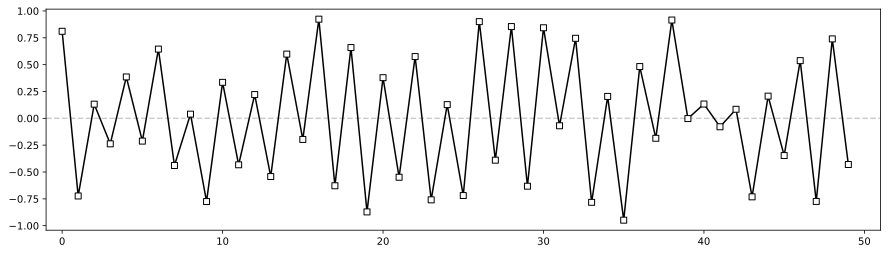

In [4]:
## Create temporal sequence data
# Import the data
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1) ** i

plt.figure(figsize=(15, 4))
plt.plot([-1, N + 1], [0, 0], "--", color=[0.8, 0.8, 0.8])
plt.plot(data.cpu(), "ks-", markerfacecolor="w")
plt.xlim([-1, N + 1])
plt.show()


In [5]:
## Create a class for the RNN DL model
class rnnnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()

        # RNN Layers
        self.rnn = nn.RNN(input_size, num_hidden, num_layers)

        # Linear layer for output
        self.out = nn.Linear(num_hidden, 1)

    def forward(self, x):
        # Run through the RNN Layer
        y, hidden = self.rnn(x) # There will be no explicit hidden state initialization

        # And the output (linear) layer
        y = self.out(y)

        return y, hidden
